In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2
# ----------------------------------------------------------------------------------------------
# python modules
import numpy as np
import matplotlib.pyplot as plt
import time
# ----------------------------------------------------------------------------------------------
# METIS modules
import constants
import setup_atm
import absopac  
import integrate_transits

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
success reading: Tables/EqChemAbund/abundance_0.100solar_rainoutTiVH2OFe.dat.gz
success reading: Tables/EqChemAbund/abundance_0.316solar_rainoutTiVH2OFe.dat.gz
success reading: Tables/EqChemAbund/abundance_1.000solar_rainoutTiVH2OFe.dat.gz
success reading: Tables/EqChemAbund/abundance_3.160solar_rainoutTiVH2OFe.dat.gz
success reading Tables/GasOpacity/absopac.noTiOVO.0.100solar.dat
success reading Tables/GasOpacity/absopac.noTiOVO.0.316solar.dat
success reading Tables/GasOpacity/absopac.noTiOVO.1.000solar.dat
success reading Tables/GasOpacity/absopac.noTiOVO.3.160solar.dat
success reading Tables/Rayleigh/rayleigh.0.100solar.dat.gz
success reading Tables/Rayleigh/rayleigh.0.316solar.dat.gz
success reading Tables/Rayleigh/rayleigh.1.000solar.dat.gz
success reading Tables/Rayleigh/rayleigh.3.160solar.dat.gz


In [3]:
def gasOpacFunc(Z,T,P, wlrange):
    '''
     expects Z in units of Z solar
     expects T in Kelvin, P in pascals
     expects T and P to be 1d arrays of equal length
     expects wlrange to be a 1d array of wavelengths in microns
     
     returns the inverse mean free path in units 1/m
    '''
    mu = absopac.mu_func(Z,T,P) # use a varying mean molecular weight throughout the atmosphere
    rho = setup_atm.eos_idealgas(P, mu*constants.gmol_to_kg, T) # use the ideal gas equation of state
    gas = absopac.gasopac_func(Z, wlrange, T, rho)
    rayleigh = absopac.rayleigh_func(Z, wlrange, T, rho)
    return gas + rayleigh # units are light blocked per m, has shape (nT, nwl) or (nwl,) if nz=1


nalt  = 60 # number of altitude grid layers
nlong = 60 # number of longitude grid points
nlat  = 60 # number of latitude grid points

wlrange = np.logspace(np.log10(0.5),np.log10(5.0),1000) # wavelength array for output spectrum, in microns
nwl = len(wlrange) 

P0 = 10**4.15                # reference pressure in Pascals
Z  = 1.0                     # metallicity in multiples of Z_sun
Mp = 0.48*constants.Mj       # mass of the planet in kg
R0 = 1.2*constants.Rj        # reference radius for the planet where all wavelengths are opaque, in meters
Rstar = 1.05*constants.Rsun  # radius of host star in meters 
Temp = 1350                  # isothermal temperature

In [4]:
# set up the atmosphere as a set of temperatures and pressures  
# on a 3d grid defined by altitude, longitude, latitude
solved_atm = setup_atm.atm_setup_1d(Temp,Mp,R0,P0,nwl,nalt,nlong,nlat,absopac.mu_func,Z)

# unpack the associated quantities that setup_atm.atm_setup_1d solved for into separate variables
Temps, Pressures, alt_range, long_range, lat_range, atmosphere_grid = solved_atm

# feed those structural quantities into the transit integration routine
clear1d_tspec = integrate_transits.effective_area_at_full_depth_no_long_dep(alt_range, long_range, 
            lat_range, Temps, Pressures, gasOpacFunc, nwl, 100, Z, wlrange)/(np.pi*Rstar**2.0) 

(0.5, 5.0, 1.3, 1.6)

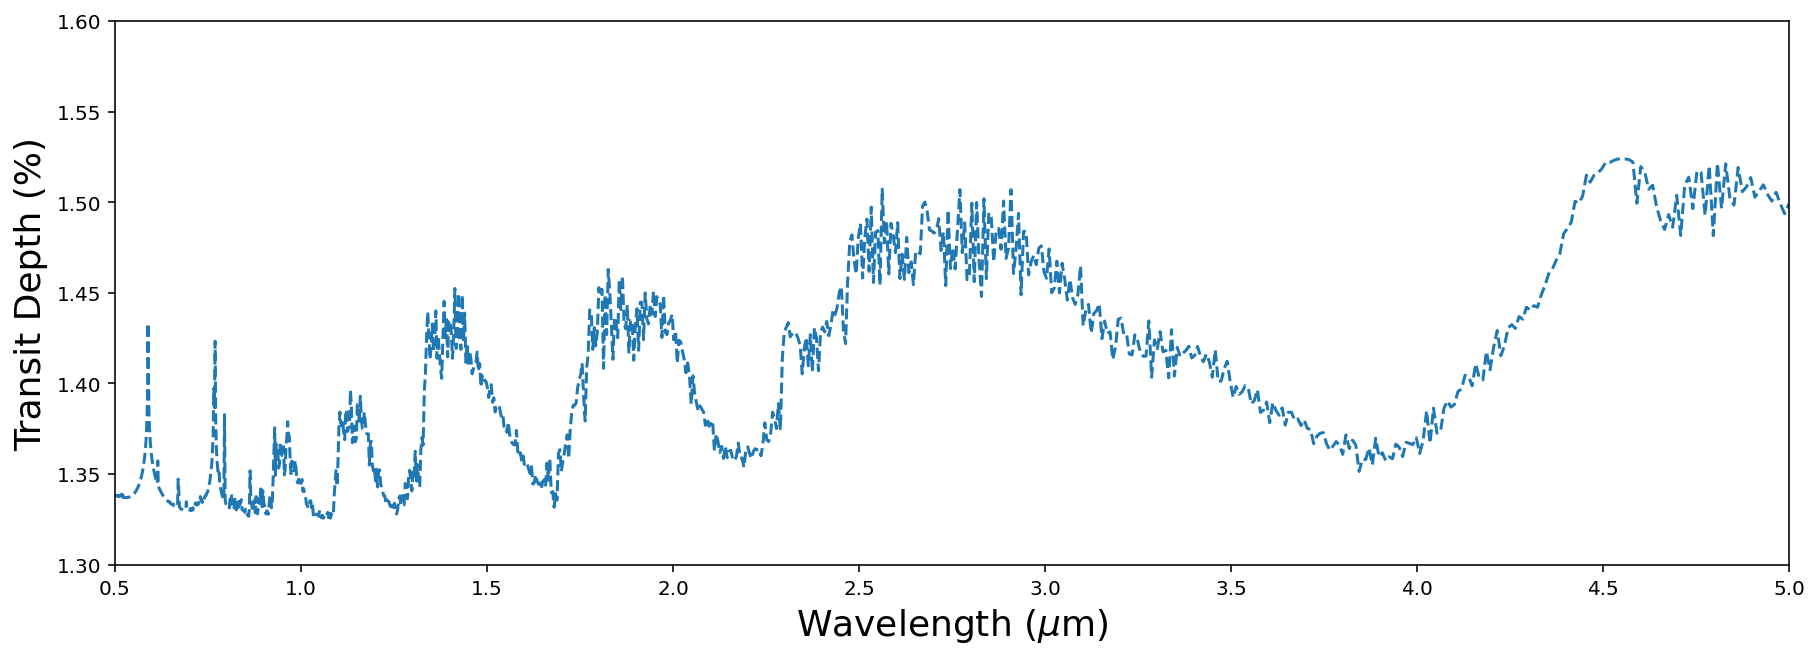

In [5]:
# plot up your results 
plt.figure(figsize=(15,5))
plt.plot(wlrange,clear1d_tspec*100,linestyle='--')
plt.xlabel('Wavelength ($\mu$m)',fontsize=18)
plt.ylabel('Transit Depth (%)',fontsize=18)
plt.axis([0.5,5,1.3,1.6])